# Test of Eyes CNN Locator

## Introduction

This is a test of the fastai CNN model (as shown in an earlier blog post).  We load up the model, and the test the model of a completely different database of face image than that used to train the model.  I am most interested in the limitations or failure modes of the model we have trained.

The test database is the [Yale Face Database](https://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/).

----------------
## Implementation

### Magics

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [0]:
from fastai.vision import *

### Access Google Drive Face Database

The databases are stored on Google Drive.

In [12]:
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Get the path to the training database.

In [0]:
path = Path('/content/gdrive/My Drive/FaceDatabase/BioID-FaceDatabase-V1.2')

### Define supporting functions

In [0]:
def get_eyes(imagepath):
  '''
  get_eyes:  returns the center of the eyes for the image at imagepath
  
  Parameters:
  imagepath: Path object pointing to image file; must have corresponding .eye file
  
  returns
  Tensor(y1, x1, y2, x2)
  '''
  
  txtpath = imgpath2txtpath(imagepath)
  xy_eyes = np.genfromtxt(txtpath)
  
  # NOTE: fastai convention is to have y,x coords (ie row, col)
  
  return tensor([ [xy_eyes[1], xy_eyes[0]], 
                  [xy_eyes[3], xy_eyes[2]] ])
#end get_eyes

In [0]:
def imgpath2txtpath(img_path):
  '''
  imagpath2txtpath: converts a image Path object into a corresponding path to a file holding text eye coordinates
  
  Parameters:
  img_path - Path object for image file in BioID-FaceDatabase-V1.2
  
  Returns:
  Path object for corresponding eye coordinate file
  
  Limitations:
  No validation is done that the Path object file exists, or is a BioID image file
  '''
  txt_path = img_path.parent/(img_path.stem+'.eye')
  
  return txt_path
  
 #end imgpath2textpath

In [0]:
def get_ctr(imagepath):
  '''
  get_ctr:  returns the center of the left eye for the image at imagepath
  
  Parameters:
  imagepath: Path object pointing to image file; must have corresponding .eye file
  
  returns
  Tensor(y, x)
  '''
  
  txtpath = imgpath2txtpath(imagepath)
  xy_eyes = np.genfromtxt(txtpath)
  
  # NOTE: fastai convention is to have y,x coords (ie row, col)
  
  return tensor([xy_eyes[1], xy_eyes[0] ])
#end get_ctr

In [0]:
def get_ip(img,pts): 
  return ImagePoints(FlowField(img.size, pts), scale=True)
#end get_ip

### Define our model

We define our model, and load our previously saved trained model


In [0]:
#  Note that image warping sometime moves eye out of frame; if we have remove_out=True(default)
#  then we get a wrong size Tensor error 

data2 = (PointsItemList.from_folder(path)
        .split_by_rand_pct(valid_pct=0.2, seed=42)
        .label_from_func(get_eyes)
        .transform(get_transforms(), tfm_y=True, size=(120,160), remove_out=False)
        .databunch().normalize(imagenet_stats)
       )

Here we show examples of the images we used to train our model (in fastai terms, our DataBunches). 

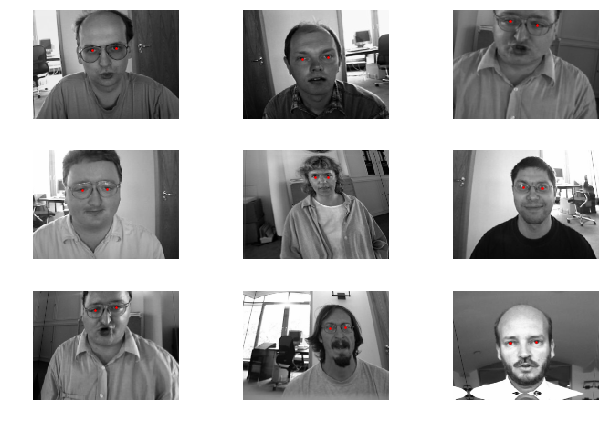

In [19]:
data2.show_batch(3, figsize=(9,6))

Define the architecture of our model.

In [20]:
learn2 = cnn_learner(data2, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 111621929.67it/s]


Load our previously saved (trained) model.

In [0]:
learn2.load('/content/gdrive/My Drive/FaceDatabase/face2-stage3');

### Access Yale Face Database

For illustrative purposes, we get the first subject, under centre lighting.

In [0]:
yale_path = Path('/content/gdrive/My Drive/FaceDatabase/yalefaces/subject01.centerlight.jpg')

In [0]:
img_yale = open_image(yale_path)

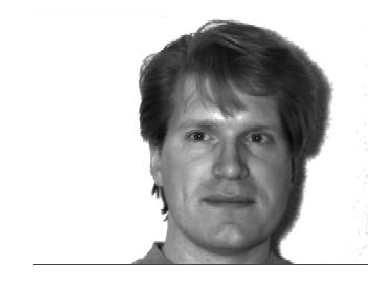

In [70]:
img_yale.show(figsize=(6,6))

Now we use the fastai CNN model to locate the eyes.

In [0]:
pred_yale = learn2.predict(img_yale)

The prediction we get back from the model is scalled to be between -1 to +1: we define a helper function to support image display.

In [72]:
pred_yale

(ImagePoints (120, 160), tensor([[-0.0766,  0.3662],
         [-0.0728,  0.0668]]), tensor([-0.0766,  0.3662, -0.0728,  0.0668]))

Define a helper function to take an image, and show the prediction location of the eyes.

In [0]:
def show_eye_predictions(model, image) -> None:
  '''
  show_eye_predictions: show the predicted eye locations for input image
  
  Parameters:
  model: fastai learner (given image, returns two scaled row,col locations)
  image: fastai Image
  
  Returns:
  None
  
  Side Effects:
  Shows image in Notebook
  '''
  
  prediction = model.predict(image)
  eye_locations = prediction[1]
  eye1 = eye_locations[0]
  eye2 = eye_locations[1]
  
  # get row and column coordinates of each eye
  r1 = float(eye1[0])
  c1 = float(eye1[1])
  
  r2 = float(eye2[0])
  c2 = float(eye2[1])
  
  # scale predicted positions from the (-1,-1) to (1,1) square
  # to image coordinates
  scaled_eye_1 = resize_predicted_point(r1, c1, image.size[0], image.size[1])
  scaled_eye_2 = resize_predicted_point(r2, c2, image.size[0], image.size[1])
  
  # create a tensor of floats for get_ip
  eye_locs = tensor(
      [ [float(scaled_eye_1[0]), float(scaled_eye_1[1]) ], 
        [float(scaled_eye_2[0]), float(scaled_eye_2[1]) ]  ]
       )
  
  
  image.show(y=get_ip(image, eye_locs), figsize=(6,6))
                     
  return None
  
#end show_eye_predictions

Show the predicted eye locations for our first Yale image.

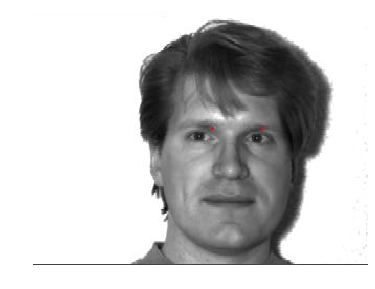

In [74]:
show_eye_predictions(learn2, img_yale)

Count the images in the Yale Face Database.

In [75]:
yale_db_path = Path('/content/gdrive/My Drive/FaceDatabase/yalefaces')

print('Yale face count = ', len(list(yale_db_path.glob('*.jpg'))))

Yale face count =  165


We now run through an example subject under different lighting conditions, and face pose.

In [0]:
faces = list(yale_db_path.glob('*.jpg'))

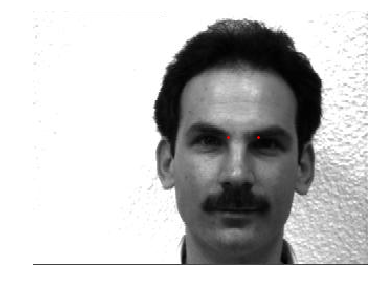

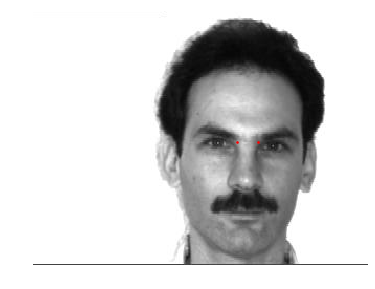

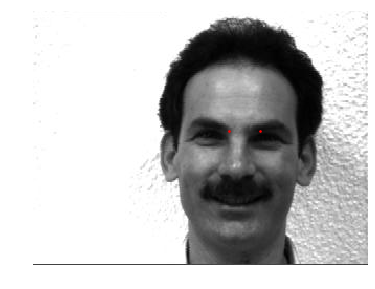

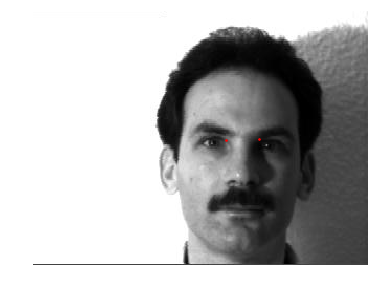

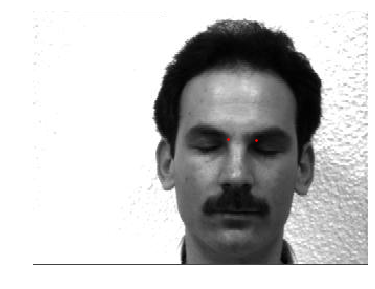

In [77]:
for f in faces[15:20]:
  f_image = open_image(f)
  show_eye_predictions(learn2, f_image)
#end for 

So far the results are reasonably OK.  Now let us look at faces in different poses.  First get all images where the subject is winking.


In [0]:
faces_wink = list(yale_db_path.glob('*wink*.jpg'))

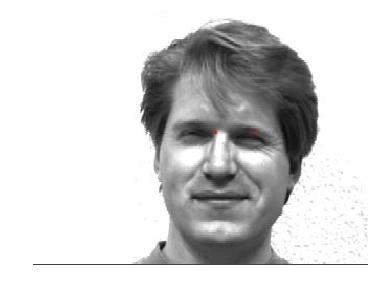

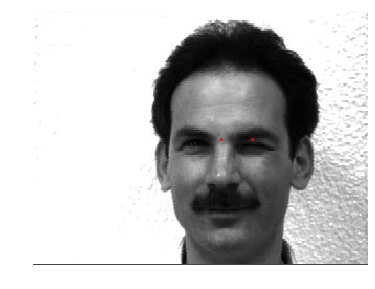

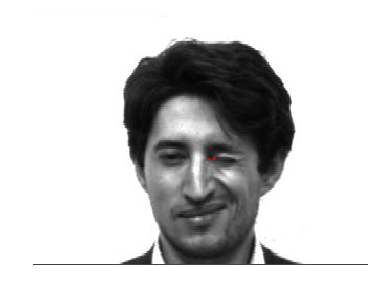

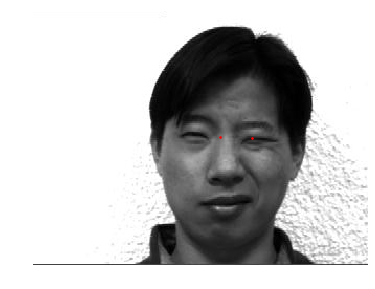

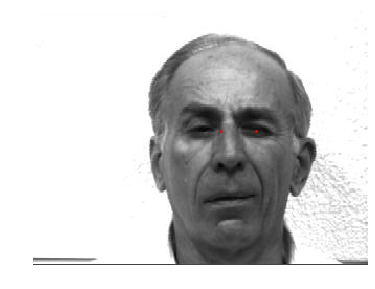

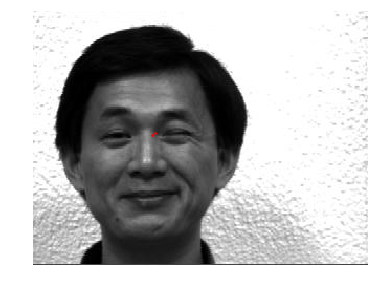

In [79]:
for f in faces_wink[0:6]:
  f_image = open_image(f)
  show_eye_predictions(learn2, f_image)
#end for 

The results are considerably worse for some subects (especially the last).

Now try images where the subject is wearing glasses.

In [0]:
faces_glasses = list(yale_db_path.glob('*.glasses*.jpg'))

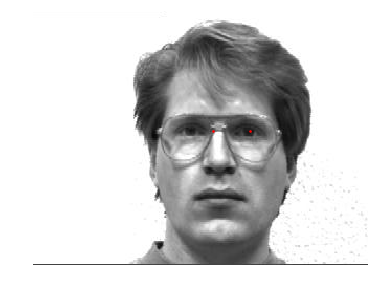

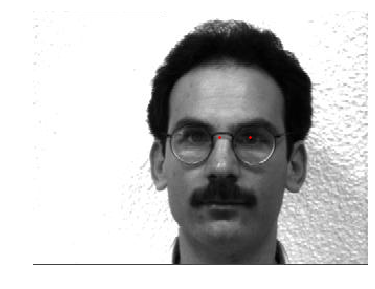

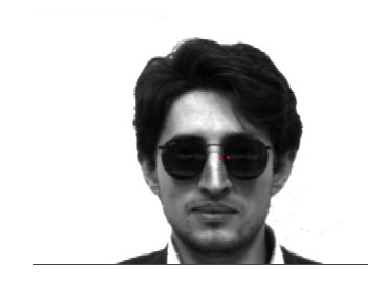

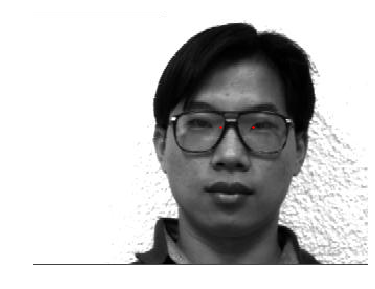

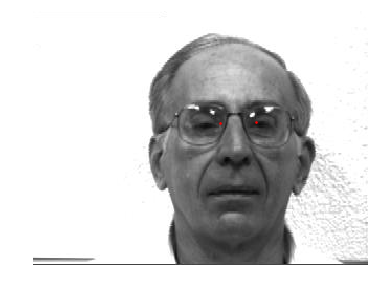

In [81]:
for f in faces_glasses[0:5]:
  f_image = open_image(f)
  show_eye_predictions(learn2, f_image)
#end for 

-------------------
## Conclusions

So we can confidently say that wearing dark glasses completely throws my model off in the X direction, but still works OK in the Y direction.  Which is interesting: it seems the the gross overall features of the face are not used, but some fine-grained features of the eye area (to be expected, seeing this is a Convolution NN).

It seems that if this model was to be used in a production setting, we would have to also define a model for winking, or glasses-wearing faces, or train our CNN model on a lot more faces in a variety of poses.